# Metoda Latin Hypercube Sampling (LHS)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import pandas as pd
from scipy import stats
import tabulate

In [2]:
%matplotlib notebook

In [3]:
def background_gradient(self, cvals=None, cmin=None, cmax=None, cmap='viridis', **css):
    """For use with `DataFrame.style.apply` this function will apply a heatmap
    color gradient *elementwise* to the calling DataFrame

    Parameters
    ----------
    self : pd.DataFrame
        The calling DataFrame. This argument is automatically passed in by the
        `DataFrame.style.apply` method

    cvals : pd.DataFrame
        If specified this DataFrame is used to determine the color gradient

    cmin : float
        If specified, any values below this will be clipped to the bottom of
        the cmap

    cmax : float
        If specified, any values above this will be clipped to the top of
        the cmap

    cmap : colormap or str
        The colormap to use

    css : dict
        Any extra inline css key/value pars to pass to the styler

    Returns
    -------
    pd.DataFrame
        The css styles to apply

    """
    from matplotlib import cm
    from matplotlib.colors import rgb2hex
    if cvals is None:
        cvals = self.values.ravel().copy()
    else:
        assert cvals.shape == self.shape
        cvals = cvals.values.ravel().copy()
    cvals -= cmin or cvals.min()
    cvals /= cmax or cvals.max()
    cvals = cvals.clip(0, 1)
    styles = []
    for rgb in cm.get_cmap(cmap)(cvals):
        style = [
            "{}: {}".format(key.replace('_', '-'), value)
            for key, value in css.items()
        ]
        style.append("background-color: {}".format(rgb2hex(rgb)))
        styles.append('; '.join(style))
    styles = np.asarray(styles).reshape(self.shape)
    return pd.DataFrame(styles, index=self.index, columns=self.columns)

### Vstupní náhodné veličiny
- všechny veličiny mají normální rozdělení

In [4]:
rv_a1 = stats.norm(0.1, 0.01) # m
rv_a2 = stats.norm(0.2, 0.01) # m
rv_f1 = stats.norm(15000, 1500) # N
rv_f2 = stats.norm(50000, 5000) # N
rv_l1 = stats.norm(1, 0.01) # m
rv_l2 = stats.norm(2, 0.01) # m
rv_ft1 = stats.norm(103e6, 15e6) # Pa
rv_ft2 = stats.norm(103e6, 15e6) # Pa

In [5]:
# seznam náhodných veličin - vstupních a počítaných
rv_list = ['a1', 'a2', 'f1', 'f2', 'l1', 'l2', 'ft1', 'ft2', 'e1', 'e2', 'z1', 'z2', 'z']

<IPython.core.display.Javascript object>


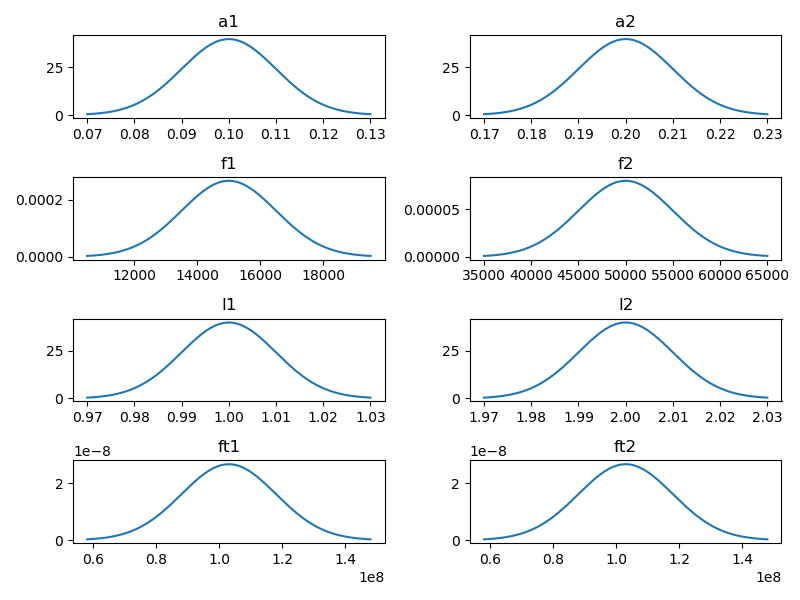

In [6]:
ncols =  2
nrows = 4
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, 6), tight_layout=True)
for i in range(nrows):
    for j in range(ncols):
        rv_name = rv_list[i * ncols + j]
        rv = locals().get('rv_' + rv_name)
        if not rv: continue
        x = np.linspace(rv.mean() - rv.std()*3, rv.mean() + rv.std()*3, 1000)
        ax[i, j].plot(x, rv.pdf(x))
        ax[i, j].set_title(rv_name)

### Výpočet metodou LHS
#### Pravděpodobnosti poruchy
- $p_{f1}$ - v řezu I
- $p_{f2}$ - v řezu II
- $p_{f}$ - celé konstrukce (minimum($Z_1$ a $Z_2$))

In [7]:
def LHS(nsim):
    # generování realizací pro jednotlivé náhodné veličiny
    p = (np.arange(nsim) + 0.5) / nsim
    a1 = rv_a1.ppf(p)
    np.random.shuffle(a1) # náhodné zamíchání vektoru
    
    a2 = rv_a2.ppf(p)
    np.random.shuffle(a2)
    
    f1 = rv_f1.ppf(p)
    np.random.shuffle(f1)
    
    f2 = rv_f2.ppf(p)
    np.random.shuffle(f2)
    
    l1 = rv_l1.ppf(p)
    np.random.shuffle(l1)
    
    l2 = rv_l2.ppf(p)
    np.random.shuffle(l2)
    
    ft1 = rv_ft1.ppf(p)
    np.random.shuffle(ft1)
    
    ft2 = rv_ft2.ppf(p)
    np.random.shuffle(ft2)

    # výpočet účinků od zatížení
    e1 = 6 * f1 * l1 / a1**3
    e2 = 6 * (f1 * l1 + f2 * l2) / a2**3 - f1 / a2**2

    # odolnost konstrukce
    r1 = ft1
    r2 = ft2

    # rezerva spolehlivosti
    z1 = r1 - e1
    z2 = r2 - e2
    z = np.minimum(z1, z2)
    
    # výpočet pravděpodobností poruchy
    pf_1 = np.sum(z1<0) / nsim
    pf_2 = np.sum(z2<0) / nsim
    pf = np.sum(z < 0) / nsim # porucha celé konstrukce (min)
    return a1, a2, f1, f2, l1, l2, ft1, ft2, e1, e2, r1, r2, z1, z2, z, pf_1, pf_2, pf

In [8]:
nsim = 1000
a1, a2, f1, f2, l1, l2, ft1, ft2, e1, e2, r1, r2, z1, z2, z, pf_1, pf_2, pf = LHS(nsim)

<IPython.core.display.Javascript object>


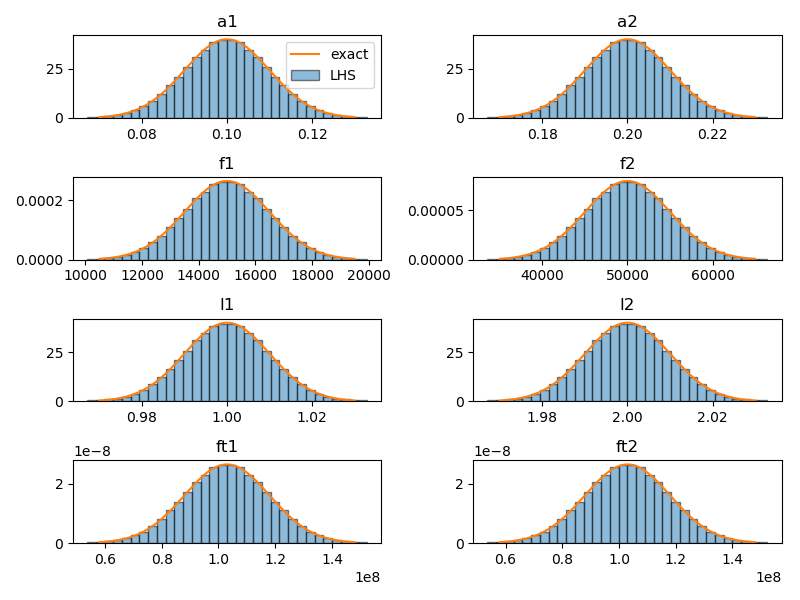

In [9]:
ncols =  2
nrows = 4
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, 6), tight_layout=True)
for i in range(nrows):
    for j in range(ncols):
        rv_name = rv_list[i * ncols + j]
        rv = locals().get('rv_' + rv_name)
        if not rv: continue
        x = np.linspace(rv.mean() - rv.std()*3, rv.mean() + rv.std()*3, 1000)
        ax[i, j].hist(locals()[rv_name], bins='sqrt', normed=True, label='LHS', alpha=.5, ec='k')
        ax[i, j].plot(x, rv.pdf(x), label='exact')
        ax[i, j].set_title(rv_name)
ax[0, 0].legend()

#### Pravděpodobnosti poruchy

In [10]:
print('pf_1 =', pf_1)
print('pf_2 =', pf_2)
print('pf =', pf)

pf_1 = 0.356
pf_2 = 0.218
pf = 0.492


#### Graf rezerv spolehlivosti

<IPython.core.display.Javascript object>


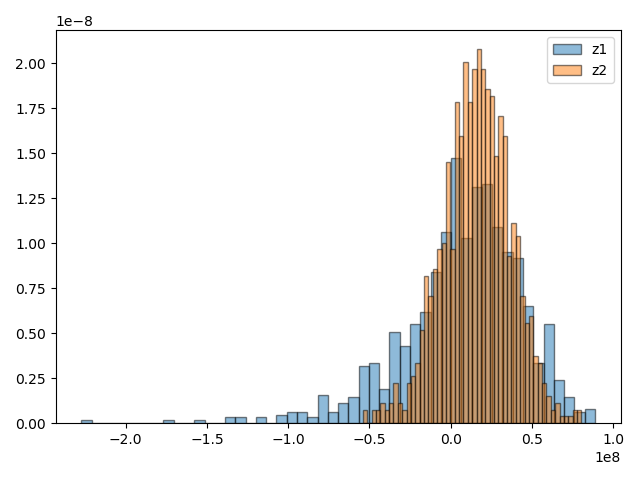

In [11]:
fig, ax = plt.subplots(tight_layout=True)
ax.hist(z1, bins=50, normed=True, alpha=.5, label='z1', ec='k')
ax.hist(z2, bins=50, normed=True, alpha=.5, label='z2', ec='k')
ax.legend();

#### Korelace mezi jednotlivými náhodnými veličinami

In [12]:
rv_arr = []
for i in rv_list:
    rv_arr.append(locals()[i])
rv_arr = np.array(rv_arr)
#print(tabulate.tabulate(np.corrcoef(rv_arr), floatfmt='.3f', tablefmt='grid', headers=rv_list, showindex=rv_list))
corr_tab = pd.DataFrame(np.corrcoef(rv_arr), index=rv_list, columns=rv_list)
display(corr_tab.style.apply(background_gradient, axis=None, cmap='bwr', cmin=-1, cmax=2).format('{:.3f}'))

#### Grafické znázornění vztahů mezi jednotlivými náhodnými veličinami

In [13]:
# počet možností
nvar = len(rv_list)
nvar * (nvar - 1) / 2

78.0

<IPython.core.display.Javascript object>


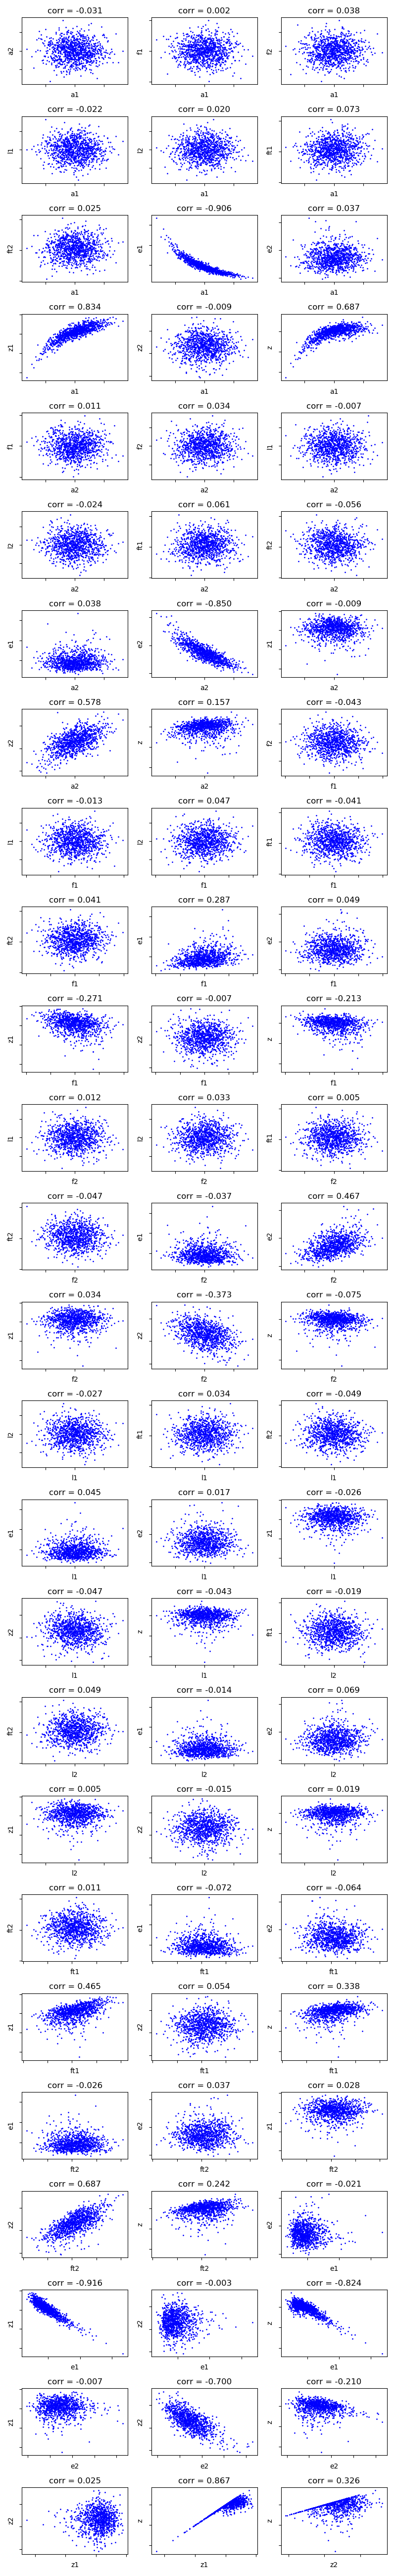

In [14]:
ncols =  3
nrows = 26
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, nrows*2), tight_layout=True)
ix, iy = 0, 0
for i in range(nvar):
    for j in range(i+1, nvar):
        rv_name_x = rv_list[i]
        rv_name_y = rv_list[j]
        x = locals()[rv_name_x]
        y = locals()[rv_name_y]
        ax[ix, iy].plot(x, y, 'b.', ms=2)
        ax[ix, iy].set_xlabel(rv_name_x)
        ax[ix, iy].set_ylabel(rv_name_y)
        ax[ix, iy].set_title('corr = {:.3f}'.format(corr_tab.loc[rv_name_x, rv_name_y]))
        ax[ix, iy].set_xticklabels([])
        ax[ix, iy].set_yticklabels([])
        iy += 1
        if iy >= ncols:
            iy = 0
            ix += 1

#### Vztah mezi rezervami spolehlivosti a ostatními náhodnými veličinami
- červeně zvýrazněny body, pro které platí $Z<0$
##### Rezerva zpolehlivosti $Z_1$

<IPython.core.display.Javascript object>


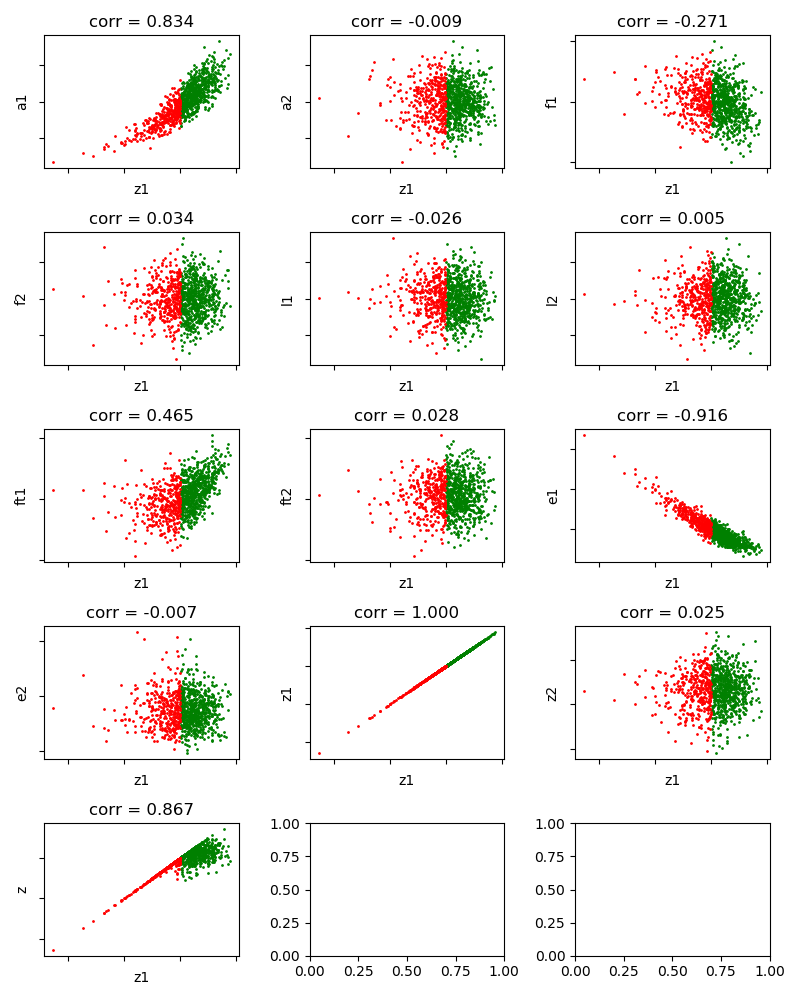

In [15]:
ncols =  3
nrows = 5
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, nrows*2), tight_layout=True)
mask = z1 < 0
ix, iy = 0, 0
for i in range(nvar):
    rv_name_x = 'z1'
    rv_name_y = rv_list[i]
    x = locals()[rv_name_x]
    y = locals()[rv_name_y]
    ax[ix, iy].plot(x[~mask], y[~mask], 'g.', ms=2)
    ax[ix, iy].plot(x[mask], y[mask], 'r.', ms=2)
    ax[ix, iy].set_xlabel(rv_name_x)
    ax[ix, iy].set_ylabel(rv_name_y)
    ax[ix, iy].set_title('corr = {:.3f}'.format(corr_tab.loc[rv_name_x, rv_name_y]))
    ax[ix, iy].set_xticklabels([])
    ax[ix, iy].set_yticklabels([])
    iy += 1
    if iy >= ncols:
        iy = 0
        ix += 1

##### Rezerva zpolehlivosti $Z_2$

<IPython.core.display.Javascript object>


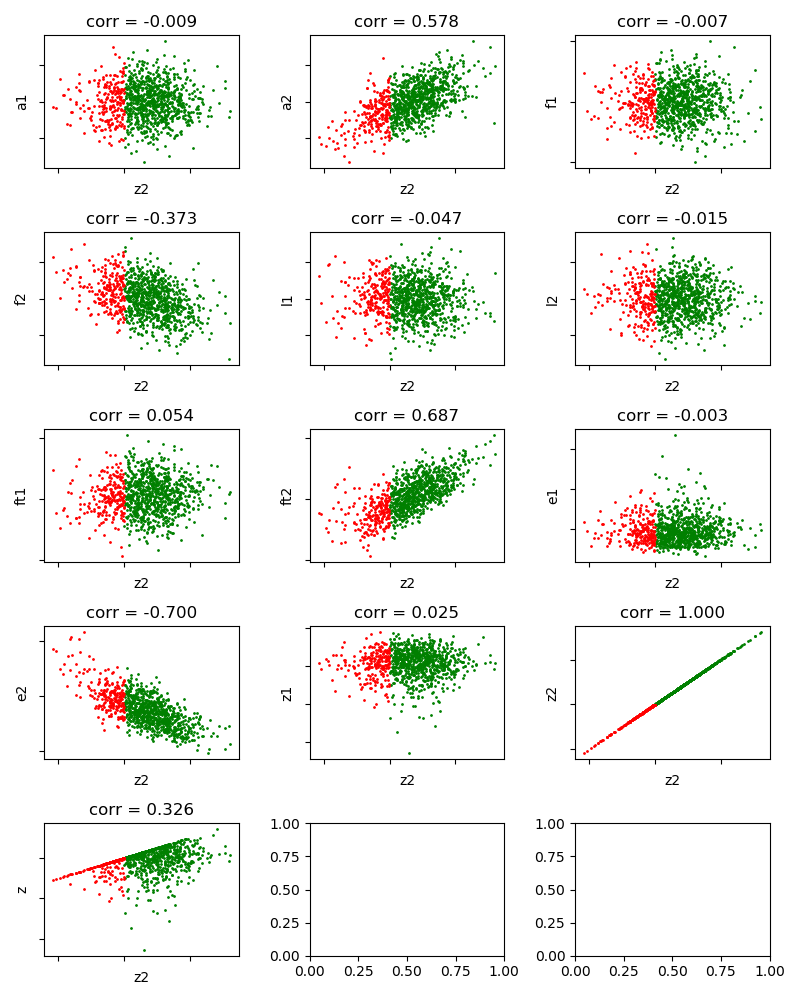

In [16]:
ncols =  3
nrows = 5
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, nrows*2), tight_layout=True)
mask = z2 < 0
ix, iy = 0, 0
for i in range(nvar):
    rv_name_x = 'z2'
    rv_name_y = rv_list[i]
    x = locals()[rv_name_x]
    y = locals()[rv_name_y]
    ax[ix, iy].plot(x[~mask], y[~mask], 'g.', ms=2)
    ax[ix, iy].plot(x[mask], y[mask], 'r.', ms=2)
    ax[ix, iy].set_xlabel(rv_name_x)
    ax[ix, iy].set_ylabel(rv_name_y)
    ax[ix, iy].set_title('corr = {:.3f}'.format(corr_tab.loc[rv_name_x, rv_name_y]))
    ax[ix, iy].set_xticklabels([])
    ax[ix, iy].set_yticklabels([])
    iy += 1
    if iy >= ncols:
        iy = 0
        ix += 1

##### Rezerva spolehlivosti $Z$

<IPython.core.display.Javascript object>


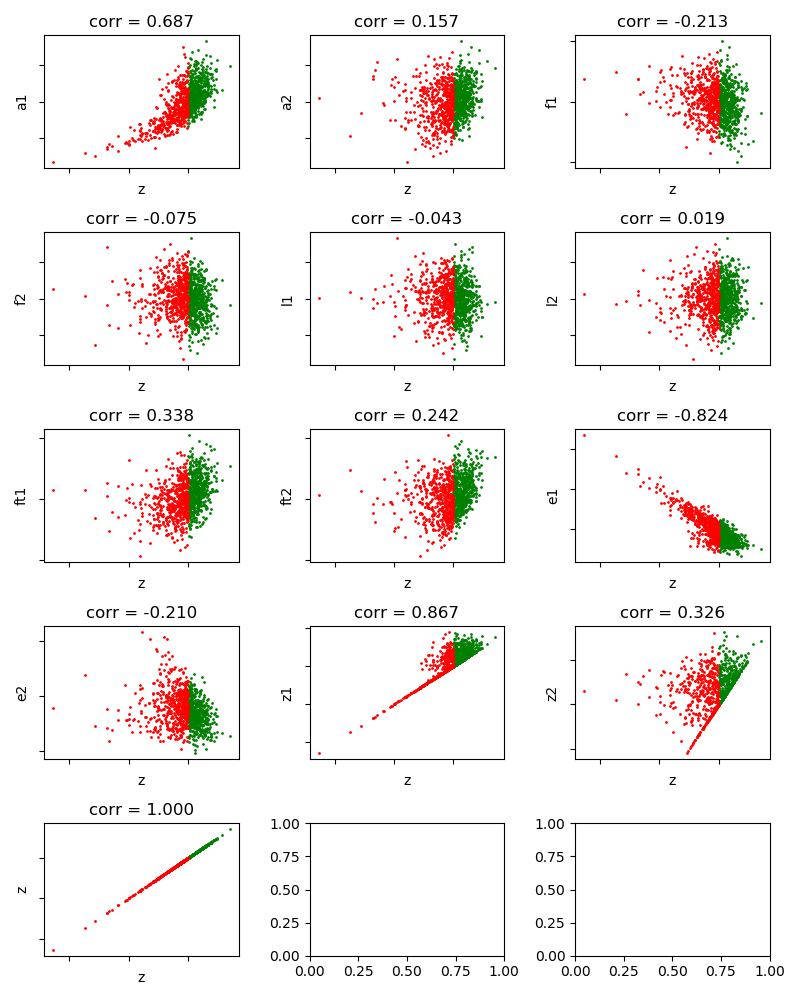

In [17]:
ncols =  3
nrows = 5
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, nrows*2), tight_layout=True)
mask = z < 0
ix, iy = 0, 0
for i in range(nvar):
    rv_name_x = 'z'
    rv_name_y = rv_list[i]
    x = locals()[rv_name_x]
    y = locals()[rv_name_y]
    ax[ix, iy].plot(x[~mask], y[~mask], 'g.', ms=2)
    ax[ix, iy].plot(x[mask], y[mask], 'r.', ms=2)
    ax[ix, iy].set_xlabel(rv_name_x)
    ax[ix, iy].set_ylabel(rv_name_y)
    ax[ix, iy].set_title('corr = {:.3f}'.format(corr_tab.loc[rv_name_x, rv_name_y]))
    ax[ix, iy].set_xticklabels([])
    ax[ix, iy].set_yticklabels([])
    iy += 1
    if iy >= ncols:
        iy = 0
        ix += 1

#### Odhad chyby metody LHS

In [18]:
nsim = 100
nrun = 1000
pfs = []
for _ in range(nrun):
    a1, a2, f1, f2, l1, l2, ft1, ft2, e1, e2, r1, r2, z1, z2, z, pf_1, pf_2, pf = LHS(nsim)
    pfs.append((pf_1, pf_2, pf))
pfs = np.array(pfs)
mu_pfs = pfs.mean(axis=0)
std_pfs = pfs.std(axis=0)
cov_pfs = std_pfs / mu_pfs
print('mu_pfs =', mu_pfs)
print('std_pfs =', std_pfs)
print('cov_pfs =', cov_pfs)

mu_pfs = [0.35947 0.22282 0.50016]
std_pfs = [0.02700406 0.02730655 0.03472138]
cov_pfs = [0.07512187 0.12254981 0.06942055]


<IPython.core.display.Javascript object>


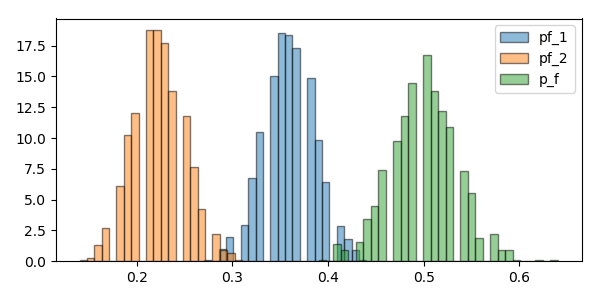

In [19]:
fig, ax = plt.subplots(figsize=(6,3), tight_layout=True)
ax.hist(pfs[:, 0], normed=True, bins='auto',
        ec='k', alpha=.5, label='pf_1')
ax.hist(pfs[:, 1], normed=True, bins='auto',
        ec='k', alpha=.5, label='pf_2')
ax.hist(pfs[:, 2], normed=True, bins='auto',
        ec='k', alpha=.5, label='p_f')
ax.legend();

In [20]:
nsim = 1000
nrun = 1000
pfs = []
for _ in range(nrun):
    a1, a2, f1, f2, l1, l2, ft1, ft2, e1, e2, r1, r2, z1, z2, z, pf_1, pf_2, pf = LHS(nsim)
    pfs.append((pf_1, pf_2, pf))
pfs = np.array(pfs)
mu_pfs = pfs.mean(axis=0)
std_pfs = pfs.std(axis=0)
cov_pfs = std_pfs / mu_pfs
print('mu_pfs =', mu_pfs)
print('std_pfs =', std_pfs)
print('cov_pfs =', cov_pfs)

mu_pfs = [0.360271 0.224261 0.502146]
std_pfs = [0.00833988 0.00841112 0.01026853]
cov_pfs = [0.0231489  0.03750593 0.02044929]


<IPython.core.display.Javascript object>


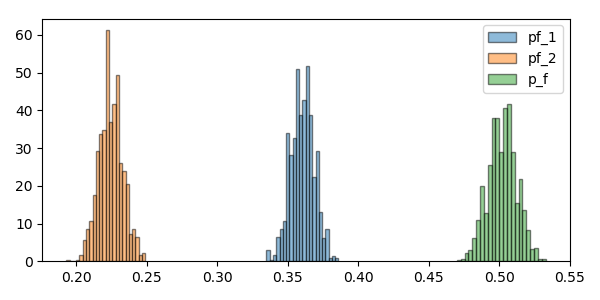

In [21]:
fig, ax = plt.subplots(figsize=(6,3), tight_layout=True)
ax.hist(pfs[:, 0], normed=True, bins='auto',
        ec='k', alpha=.5, label='pf_1')
ax.hist(pfs[:, 1], normed=True, bins='auto',
        ec='k', alpha=.5, label='pf_2')
ax.hist(pfs[:, 2], normed=True, bins='auto',
        ec='k', alpha=.5, label='p_f')
ax.legend();